# Sales data EDA

- looking for Time Series Analysis (TSA) specific components
  - Trend
  - Seasonality
  - Cyclic
  - Irregularity


- Identifying the Time Series Data type
  - Stationary or Non-Stationary
  - Using statistical tests to check if the data is Stationary
    - Augmented Dickey-Fuller (ADF) Test
    - Kwiatkowski-Plillips-Schmidt-Shin (KPSS) Test



- Converting data to Stationary type
  - Detrending
  - Deferencing

## Imports

In [1]:
import sys
sys.path.append('../')

import random
import pandas as pd

from src.fetch_data import DataLoader
from src.exploration import Analysis
from src.cleaning import CleanDataFrame
from src.visualization import Plotters
from src.rotating_logs import get_rotating_log

import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('seaborn')
sns.set()
import plotly.express as px
import plotly.graph_objects as go


cleaner = CleanDataFrame()
analyzer = Analysis()
plotters = Plotters(w=6, h=4)

# pd.options.plotting.backend = 'matplotlib'
import matplotlib as mpl
plt.rc('font', size=20)  
%matplotlib inline

In [2]:
# First load the cleaned stores data
data_path = 'data/cleaned/store.csv'
version = 'stores_missing_filled_v2'
repo = '../'

store_df = DataLoader.dvc_get_data(data_path, version, repo)

# Then load the raw sales data
data_path = 'data/raw/train.csv'
version = 'raw_data'
repo = '../'

sales_df = DataLoader.dvc_get_data(data_path, version, repo)

DataLoaderLogger - INFO - DVC: CSV file read with path: data/cleaned/store.csv | version: stores_missing_filled_v2 | from: ../
/home/hat/dev-env/10Acadamy/week_3/Rossmann-Pharmaceuticals-Sales-Forcast/notebooks/../src/fetch_data.py:28: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(content), sep=",")
DataLoaderLogger - INFO - DVC: CSV file read with path: data/raw/train.csv | version: raw_data | from: ../


## Highlight of the two dataframes

In [3]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,none
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,none
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,none


In [4]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1115 non-null   float64
 4   CompetitionOpenSinceMonth  1115 non-null   object 
 5   CompetitionOpenSinceYear   1115 non-null   float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            1115 non-null   float64
 8   Promo2SinceYear            1115 non-null   float64
 9   PromoInterval              1115 non-null   object 
dtypes: float64(4), int64(2), object(4)
memory usage: 87.2+ KB


In [5]:
sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


First, Let's see the date range of our data.

In [7]:
sales_df['Date'] = pd.to_datetime(sales_df['Date'])
start_date, end_date = sales_df['Date'].aggregate([min, max])
print(f"start_date: {start_date.date()} ----> end_date: {end_date.date()}")

start_date: 2013-01-01 ----> end_date: 2015-07-31


Next, I will check if there are any missing dates in the data. 

In [8]:
unique_dates = sales_df['Date'].unique()
print(f"There are {len(unique_dates)} unique dates in the data.\nThe number of days between the end and start date is {(end_date-start_date).days}")


There are 942 unique dates in the data.
The number of days between the end and start date is 941


## Merge sales and stores dataframes

In [9]:
df = pd.merge(sales_df, store_df, how='inner', on='Store')
df.set_index('Date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Sales                      1017209 non-null  int64  
 3   Customers                  1017209 non-null  int64  
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   StoreType                  1017209 non-null  object 
 9   Assortment                 1017209 non-null  object 
 10  CompetitionDistance        1017209 non-null  float64
 11  CompetitionOpenSinceMonth  1017209 non-null  object 
 12  CompetitionOpenSinceYear   1017209 non-null  float64
 1

In [10]:

df['Year'] = df.index.year
df['Month'] = df.index.month
df['WeekOfYear'] = df.index.isocalendar().week
df['SalesPerCustomer'] = df['Sales'] / df['Customers']
df[['SalesPerCustomer', 'Sales']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SalesPerCustomer,844340.0,9.493619,2.197494,0.0,7.895563,9.25,10.899729,64.957854
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.000000,5744.00,7856.000000,41551.000000


I will see the statistical properties of the dataframe by grouping with storetype

There are 1017209 individual data points. I can't visualize all of them properly. 
I will be grouping based on DayOfWeek, store type and assortment.

### Group by `DayOfWeek`

<AxesSubplot:title={'center':'Sales on each DayOfWeek for 3 years'}, xlabel='DayOfWeek', ylabel='Sales sum per DayOfWeek'>

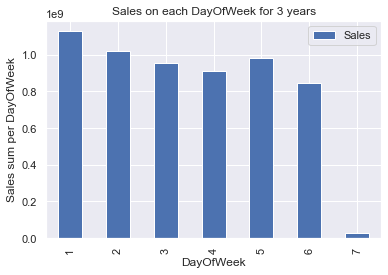

In [11]:
grouped_by_day = df.groupby('DayOfWeek')['Sales'].sum().to_frame()
# colors = ['g', 'b', 'g', 'w', 'r', 'b', 'y']
grouped_by_day.plot(kind='bar',
                        xlabel="DayOfWeek", 
                        ylabel='Sales sum per DayOfWeek', 
                        title='Sales on each DayOfWeek for 3 years',
                        label='DayOfWeek',)
                        # color=colors)
# grouped_by_day

The above plot shows each days sales sum through out the three years.

The highest sales is on Mondays and the Lowest is on Sundays. 
This observation is assuming the week day starts at Monday.

Next, I will group the data with Year in addition to the DayOfWeek to see if the pattern holds.

<AxesSubplot:title={'center':'Sales through the Years grouped by DayOfWeek'}, xlabel='Year and DayOfWeek', ylabel='Sales sum per DayOfWeek'>

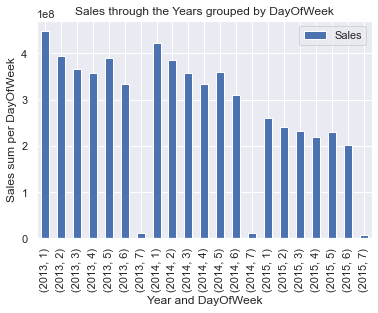

In [12]:

grouped_by_year_day = df.groupby(['Year', 'DayOfWeek'])['Sales'].sum().to_frame()
# colors = ['g', 'b', 'g', 'w', 'r', 'b', 'y']
grouped_by_year_day.plot.bar(xlabel="Year and DayOfWeek", 
                            ylabel='Sales sum per DayOfWeek', 
                            title='Sales through the Years grouped by DayOfWeek',)
                            # color=colors)


This shows us that the above trend holds. In addition, we can see that the sale has been decreasing through the years. 

Next, I will look at which stores are doing good based on `StoreType` and `Assortment`

### Group by `StoreType`

<AxesSubplot:xlabel='StoreType'>

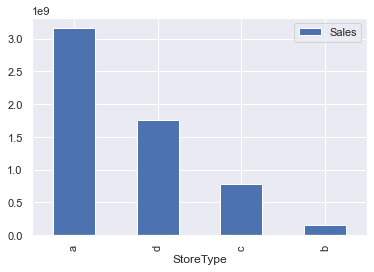

In [13]:
grouped_by_storetype = df.groupby('StoreType')['Sales'].sum().to_frame().sort_values(by='Sales', ascending=False)
# store_type_color = {'a': 'blue', 'b': 'red', 'c': 'green', 'd': 'teal'}
grouped_by_storetype.plot.bar()


<AxesSubplot:title={'center':'Sales through the Years grouped by StoreType'}, xlabel='Year and StoreType', ylabel='Sales sum per StoreType'>

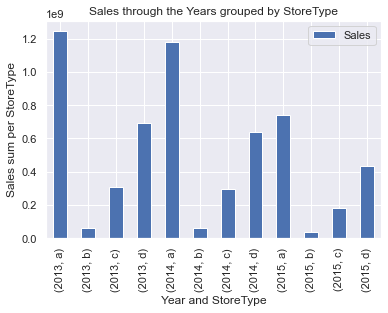

In [14]:
grouped_by_year_storetype = df.groupby(['Year', 'StoreType'])['Sales'].sum().to_frame()
grouped_by_year_storetype.plot.bar(xlabel="Year and StoreType", ylabel='Sales sum per StoreType', title='Sales through the Years grouped by StoreType')


In all three years, there is a trend. 

- Store 'a' has the highest sales. Then 'd', 'c', and 'b' in that order

### Groupby `Assortment`

<AxesSubplot:title={'center':'Sales through the Years grouped by Assortment'}, xlabel='Year and Assortment', ylabel='Sales sum per Assorment'>

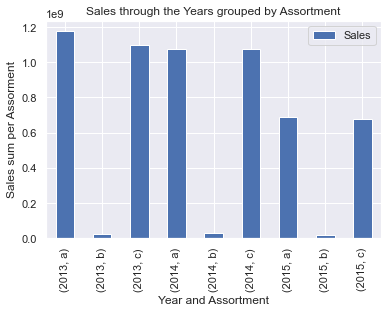

In [15]:
grouped_by_year_assortment = df.groupby(['Year', 'Assortment'])['Sales'].sum().to_frame()
grouped_by_year_assortment.plot.bar(xlabel="Year and Assortment", ylabel='Sales sum per Assorment', title='Sales through the Years grouped by Assortment')


# Question Guided EDA


In [16]:
# load the raw test data
data_path = 'data/raw/test.csv'
version = 'raw_data'
repo = '../'

test_df = DataLoader.dvc_get_data(data_path, version, repo)

DataLoaderLogger - INFO - DVC: CSV file read with path: data/raw/test.csv | version: raw_data | from: ../


In [17]:
test_df = pd.merge(test_df, store_df, how='inner', on='Store')
test_df.set_index('Date', inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41088 entries, 2015-09-17 to 2015-08-01
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Id                         41088 non-null  int64  
 1   Store                      41088 non-null  int64  
 2   DayOfWeek                  41088 non-null  int64  
 3   Open                       41077 non-null  float64
 4   Promo                      41088 non-null  int64  
 5   StateHoliday               41088 non-null  object 
 6   SchoolHoliday              41088 non-null  int64  
 7   StoreType                  41088 non-null  object 
 8   Assortment                 41088 non-null  object 
 9   CompetitionDistance        41088 non-null  float64
 10  CompetitionOpenSinceMonth  41088 non-null  object 
 11  CompetitionOpenSinceYear   41088 non-null  float64
 12  Promo2                     41088 non-null  int64  
 13  Promo2SinceWeek            41088 non-

## 1. Are the promotions distributed similarly in both training and test sets?

YES


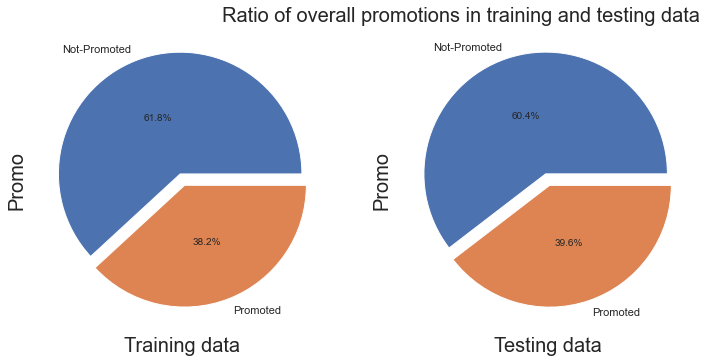

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
lable_font_size = 20
labels = {'Not-Promoted':0, 'Promoted':1}
train_promo_count = df["Promo"].value_counts().to_frame()
axs[0].pie(data=train_promo_count,
                x='Promo',
                autopct="%.1f%%", 
                explode=[0.05]*2, 
                labels=labels, 
                pctdistance=0.5,
                )
axs[0].set_label(labels)
axs[0].set_ylabel('Promo', fontsize=lable_font_size)
axs[0].set_xlabel('Training data', fontsize=lable_font_size)

test_promo_count = test_df["Promo"].value_counts().to_frame()
axs[1].pie(data=test_promo_count,
                x='Promo',
                autopct="%.1f%%", 
                explode=[0.05]*2, 
                labels=labels, 
                pctdistance=0.5,
                )

axs[1].set_ylabel('Promo', fontsize=lable_font_size)
axs[1].set_xlabel('Testing data', fontsize=lable_font_size)

plt.title("Ratio of overall promotions in training and testing data", fontsize=20, loc='right')

print("YES")

## What does sales behavior look like before, during and after holidays?

In [37]:
df[['StateHoliday', 'SchoolHoliday']]

,StateHoliday,SchoolHoliday
Date,,
2015-07-31,0,1
2015-07-30,0,1
2015-07-29,0,1
2015-07-28,0,1
2015-07-27,0,1
...,...,...
2013-01-05,0,1
2013-01-04,0,1
2013-01-03,0,1


In [39]:
df.query("StateHoliday!='0'")['StateHoliday']

Date
2015-06-04    a
2015-05-25    a
2015-05-14    a
2015-05-01    a
2015-04-06    b
             ..
2013-05-09    a
2013-05-01    a
2013-04-01    b
2013-03-29    b
2013-01-01    a
Name: StateHoliday, Length: 162122, dtype: object